<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Общая-цель" data-toc-modified-id="Общая-цель-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Общая цель</a></span></li><li><span><a href="#Парсим-Headhunter" data-toc-modified-id="Парсим-Headhunter-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Парсим Headhunter</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><span><a href="#Общие-распределения" data-toc-modified-id="Общие-распределения-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Общие распределения</a></span></li><li><span><a href="#Распределение-ЗП-по-всей-выборке" data-toc-modified-id="Распределение-ЗП-по-всей-выборке-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Распределение ЗП по всей выборке</a></span></li><li><span><a href="#Распределение-по-Москве" data-toc-modified-id="Распределение-по-Москве-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Распределение по Москве</a></span></li><li><span><a href="#Распределение-по-уровням-junior,-middle,-senior-по-Москве" data-toc-modified-id="Распределение-по-уровням-junior,-middle,-senior-по-Москве-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Распределение по уровням junior, middle, senior по Москве</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

Импорт библиотек:

In [1]:
import pandas as pd
import json
import requests as rq
import numpy as np
# from io import StringIO
import math
import seaborn as sns
import matplotlib.pyplot as plt

### Общая цель

Исследование проводила лично для себя и собственного понимания. Понятно, что многое зависит от договоренностей, но поскольку я аналитик, я могу собрать реальные данные и полагаться на них)  

1. Есть зарплатный калькулятор Хабра, где люди моей профессии сами пишут свой уровень ЗП. Это - факт;
2. Есть предложение вакансий с Хедхантера - я взяла выгрузку вакансий, где указан предлагаемый уровень зарплаты. Это - "план", предложение рынка;
3. Мне было интересно, насколько фактические данные с Хабра сходятся с предложением Хедхантера.    

Средний рыночный уровень зарплаты на январь 2025 г. для системного аналитика для всех уровней составляет `191 000 руб` (медиана), для уровня middle - `170 000 руб`. При этом подавляющее большинство лежит в пределах от 117 000 до 238 000 руб для уровня middle (по всем уровням не рассматриваю, т.к. слишком большой разброс).  

Что ж, с фактическими данными все понятно, проанализируем предложение.

### Парсим Headhunter

Сайт недоступен для парсинга различными роботами. При этом у HH есть официальное API, к которому можно подключиться. Большая часть запросов требует авторизации, но поисковая выдача по вакансиям доступна без авторизации, мне этих данных будет достаточно.

Адрес для запроса поисковой выдачи:

In [2]:
main = "https://api.hh.ru/vacancies?text=системный+аналитик"

Также для API HH обязательно указание заголовка `User-Agent`:

In [3]:
headers = {
    'Content-Type': 'application/json',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/131.0.0.0 Safari/537.36'
}

Загружаем поисковую выдачу в переменную:

In [4]:
main_page = rq.get(main, headers=headers)

In [5]:
main_page.status_code

200

In [6]:
# main_page.text

Для начала прочитаем полученный JSON-объект:

In [7]:
json = pd.io.json.json_normalize(main_page.json())

C:\Users\HP\AppData\Local\Temp/ipykernel_14636/1700753292.py:1: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  json = pd.io.json.json_normalize(main_page.json())


In [8]:
json

,items,found,pages,page,per_page,clusters,arguments,fixes,suggests,alternate_url
0,"[{'id': '114823497', 'premium': False, 'name':...",3426,100,0,20,None,None,None,None,https://hh.ru/search/vacancy?enable_snippets=t...


Получили перечень полей JSON-объекта, видим, что присутствует пагинация, и мы получили первую страницу с двадцатью элементами.  

Интересно, почему не сходится общее количество найденных элементов (3415) - всего 100 страниц, по 20 элементов на каждой, итого 2000 элементов. Возможно, есть ограничение в этом запросе, по умолчанию вернется только ограниченное число элементов или страниц.  

*Опытным путем выяснила, что я оказалась права - нельзя получить в одном запросе больше 2000 элементов)*  

Вся интересная информация находится в поле `items`, остальное не представляет интереса.

Нам нужно получить все элементы, а не только первую страницу. Стандартный способ для REST  - получить все элементы на одной странице у меня не сработал, но работает указание фиксированного количества элементов на странице и постраничная выдача.  
Известно общее количество элементов, поэтому рассчитаем нужное количество страниц, исходя из него.  

*Также опытным путем выяснено, что установлен предел допустимого количества элементов на странице - не более 100. Но при выгрузке именно этим запросом API параметр будет проигнорирован, и в любом случае будет получено 20 элементов на странице. Наверняка, где-то была эта информация, но мануалы для слабаков)))*

Рассчитываем нужное количество страниц, исходя из полученного количества элементов в поле `found`. Округляем полученное значение до целого в большую сторону:

In [9]:
# указываем число элементов на странице = 20, т.к. данный запрос API для незареганных игнорирует параметр items_on_page
number = math.ceil(json['found'][0]/20)

In [10]:
number

172

In [11]:
pages = list(range(0, number))

Далее нужно получить данные для каждой страницы из списка `pages`. Сразу преобразовываем полученный `JSON` в `dataframe` и объединяем. Функция для преобразования в `dataframe` есть ниже, вызовем ее внутри функции для постраничного чтения.

In [12]:
def dict_list_to_df(dict_list):
    '''
    Получает список словарей на вход и преобразовывает в dataframe.
    Первая строка становится строкой заголовка
    '''
    df = pd.DataFrame()
    for i in dict_list:
        row_data = pd.DataFrame(list(i.items())).T
        header = row_data.iloc[0] # делаем первую строку заголовками датафрейма
        row_data = row_data[1:]
        row_data = row_data.rename(columns = header).copy()
        df = pd.concat([df,row_data]).reset_index(drop='true')
    return df

Также необходимо будет подготовить адресную строку, в которую будем подбрасывать номера страниц из списка. В адресной строке укажем название нужной вакансии также в качестве переменной - вдруг понадобится спарсить данные по другой вакансии)

In [13]:
vacancy = 'системный+аналитик'

In [14]:
main_pageable = f"https://api.hh.ru/vacancies?text={vacancy}&per_page=100&page={number}"

In [15]:
main_pageable

'https://api.hh.ru/vacancies?text=системный+аналитик&per_page=100&page=172'

In [16]:
def transform_search_result(pages):
    '''
    Получает на вход список с номерами страниц и последовательно подкидывает номер страницы в адресную строку.
    Для каждого результата чтения данных с указанной страницы возвращает HTTP-статус выполнения запроса и текст ошибки 
    в случае, если запрос не был успешным.
    Полученные данные составляет в датафрейм.
    '''
    status_list = []
    errors_list = []
    df = pd.DataFrame()
    for i in pages:
        url = f"https://api.hh.ru/vacancies?text={vacancy}&page={i}"
        json_loads = rq.get(url, headers=headers)
        if json_loads.status_code != 200:
            errors_list.append(json_loads.text)
        else:
            status_list.append(json_loads.status_code)
            json = pd.io.json.json_normalize(main_page.json())
            json = json['items'][0]
            data = dict_list_to_df(json)
            df = pd.concat([df,data]).reset_index(drop='true')
    print(status_list,errors_list) # выводим результат чтения и ошибки, если есть
    return df

In [17]:
df = transform_search_result(pages)

C:\Users\HP\AppData\Local\Temp/ipykernel_14636/3063064399.py:18: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  json = pd.io.json.json_normalize(main_page.json())


[200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200] ['{"description":"you can\'t look up more than 2000 items in the list","bad_argument":"page, per_page","bad_arguments":[{"name":"page, per_page","description":"you can\'t look up more than 2000 items in the list"}],"errors":[{"value":"page","type":"bad_argument"},{"value":"per_page","type":"bad_argument"}],"request_id":"1736267818428d88402e5806a3d91f91"}', '{"description":"you can\'t look up more than 2000 items in the list","bad_argument":"page, per_page","bad_arguments":[{"name":"page, per_pa

API для незареганных разрешает выгружать не более 2000 записей, поэтому при превышении этого количества посыпались ошибки, связанные с параметрами пагинации. Но мне хватит и полученных 2000)  
Мне нужны далеко не все данные отсюда, плюс интересуют только вакансии с указанным уровнем ЗП. Далее нас ждет блок предобработки полученных данных.

### Предобработка данных

In [18]:
df.sample(5)

,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,...,professional_roles,accept_incomplete_resumes,experience,employment,employment_form,internship,adv_response_url,is_adv_vacancy,adv_context,branding
1699,113733034,False,Аналитик второй линии поддержки,None,True,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 100000, 'to': None, 'currency': 'RUR'...","{'id': 'open', 'name': 'Открытая'}",None,...,"[{'id': '121', 'name': 'Специалист технической...",False,"{'id': 'between1And3', 'name': 'От 1 года до 3...","{'id': 'full', 'name': 'Полная занятость'}","{'id': 'FULL', 'name': 'Полная'}",False,None,False,None,"{'type': 'MAKEUP', 'tariff': None}"
968,111417913,False,Стажер/ Младший системный аналитик,None,False,True,"{'id': '2', 'name': 'Санкт-Петербург', 'url': ...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': None, 'street': None, 'building': Non...",...,"[{'id': '148', 'name': 'Системный аналитик'}]",False,"{'id': 'noExperience', 'name': 'Нет опыта'}","{'id': 'probation', 'name': 'Стажировка'}","{'id': 'FULL', 'name': 'Полная'}",True,None,False,None,NaN
874,115049557,False,Системный аналитик,None,False,False,"{'id': '160', 'name': 'Алматы', 'url': 'https:...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Астана', 'street': 'проспект Рахимжа...",...,"[{'id': '148', 'name': 'Системный аналитик'}]",False,"{'id': 'between1And3', 'name': 'От 1 года до 3...","{'id': 'full', 'name': 'Полная занятость'}","{'id': 'FULL', 'name': 'Полная'}",False,None,False,None,NaN
546,112502113,False,Системный аналитик,None,False,False,"{'id': '2', 'name': 'Санкт-Петербург', 'url': ...","{'from': 180000, 'to': None, 'currency': 'RUR'...","{'id': 'open', 'name': 'Открытая'}","{'city': 'Санкт-Петербург', 'street': 'Невский...",...,"[{'id': '148', 'name': 'Системный аналитик'}]",False,"{'id': 'between1And3', 'name': 'От 1 года до 3...","{'id': 'full', 'name': 'Полная занятость'}","{'id': 'FULL', 'name': 'Полная'}",False,None,False,None,NaN
1450,115066186,False,Системный аналитик,None,False,False,"{'id': '1002', 'name': 'Минск', 'url': 'https:...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Минск', 'street': 'переулок Козлова'...",...,"[{'id': '148', 'name': 'Системный аналитик'}]",False,"{'id': 'between1And3', 'name': 'От 1 года до 3...","{'id': 'full', 'name': 'Полная занятость'}","{'id': 'FULL', 'name': 'Полная'}",False,None,False,None,NaN


Что будем делать:  
1. Оставим только нужные столбцы;
2. Удалим строки, где не заполнено поле `salary`;
3. Параметр `area` также игнорируется в запросе (либо его нужно передавать как-то иначе), поэтому далее разберем поле `area` на составляющие, чтобы выделить город;
4. Развернем поле `salary` на параметры "от" и "до";
5. Развернем параметр `type`, кажется, что там есть тип "Открытая" и "Закрытая" вакансия;
6. Развернем параметры с формой занятости и опытом, они также могут потребоваться;

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 44 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   id                         2000 non-null   object
 1   premium                    2000 non-null   object
 2   name                       2000 non-null   object
 3   department                 0 non-null      object
 4   has_test                   2000 non-null   object
 5   response_letter_required   2000 non-null   object
 6   area                       2000 non-null   object
 7   salary                     1400 non-null   object
 8   type                       2000 non-null   object
 9   address                    1000 non-null   object
 10  response_url               0 non-null      object
 11  sort_point_distance        0 non-null      object
 12  published_at               2000 non-null   object
 13  created_at                 2000 non-null   object
 14  archived

Убираем ненужные столбцы, а точнее, оставляем только нужные. Избавляемся от пропусков в столбце `salary`:

In [20]:
data = df[[
    'id','name','salary','type', 'area', 'employment_form', 'experience'
]].dropna(subset=['salary']).reset_index(drop='true')

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               1400 non-null   object
 1   name             1400 non-null   object
 2   salary           1400 non-null   object
 3   type             1400 non-null   object
 4   area             1400 non-null   object
 5   employment_form  1400 non-null   object
 6   experience       1400 non-null   object
dtypes: object(7)
memory usage: 76.7+ KB


Из 2000 вакансий 1400 - с указанием зарплаты, неплохо. Теперь нужно развернуть все вложенные поля, это все поля кроме собственно `id` и наименования вакансии.  
Каждый из этих столбцов содержит в себе словарь:

In [22]:
print(data['salary'][0])
print(data['area'][0])
print(data['type'][0])
print(data['employment_form'][0])
print(data['experience'][0])

{'from': 100000, 'to': 150000, 'currency': 'RUR', 'gross': False}
{'id': '1', 'name': 'Москва', 'url': 'https://api.hh.ru/areas/1'}
{'id': 'open', 'name': 'Открытая'}
{'id': 'FULL', 'name': 'Полная'}
{'id': 'noExperience', 'name': 'Нет опыта'}


И это означает, что можно применить к каждому из этих столбцов функцию преобразования в `dataframe`,которую уже использовали выше:

In [23]:
columns_list = ['salary', 'area', 'type', 'employment_form', 'experience']

In [24]:
data.head()

,id,name,salary,type,area,employment_form,experience
0,114823497,Junior IT специалист / системный аналитик,"{'from': 100000, 'to': 150000, 'currency': 'RU...","{'id': 'open', 'name': 'Открытая'}","{'id': '1', 'name': 'Москва', 'url': 'https://...","{'id': 'FULL', 'name': 'Полная'}","{'id': 'noExperience', 'name': 'Нет опыта'}"
1,109429555,Cтажер - Системный аналитик,"{'from': None, 'to': 25000, 'currency': 'RUR',...","{'id': 'open', 'name': 'Открытая'}","{'id': '1', 'name': 'Москва', 'url': 'https://...","{'id': 'FULL', 'name': 'Полная'}","{'id': 'noExperience', 'name': 'Нет опыта'}"
2,112157349,Системный аналитик,"{'from': 240000, 'to': None, 'currency': 'RUR'...","{'id': 'open', 'name': 'Открытая'}","{'id': '1', 'name': 'Москва', 'url': 'https://...","{'id': 'FULL', 'name': 'Полная'}","{'id': 'between1And3', 'name': 'От 1 года до 3..."
3,115069237,Системный аналитик,"{'from': 250000, 'to': 380000, 'currency': 'RU...","{'id': 'open', 'name': 'Открытая'}","{'id': '1', 'name': 'Москва', 'url': 'https://...","{'id': 'FULL', 'name': 'Полная'}","{'id': 'between1And3', 'name': 'От 1 года до 3..."
4,115060566,Системный аналитик,"{'from': 230000, 'to': 280000, 'currency': 'RU...","{'id': 'open', 'name': 'Открытая'}","{'id': '2', 'name': 'Санкт-Петербург', 'url': ...","{'id': 'FULL', 'name': 'Полная'}","{'id': 'between3And6', 'name': 'От 3 до 6 лет'}"


In [25]:
def transform_dict_df_to_norm(df, columns_list):
    '''
    Принимает на вход dataframe и список столбцов, которые нужно преобразовать.
    Столбцы датафрейма должны содержать в каждой строке словарь.
    Проверяет наличие каждого столбца из списка в датафрейме, и если такой столбец есть, то разворачивает словарь:
    Каждому ключу словаря соответствует столбец с названием ключа. Полученный датафрейм присоединяет к исходному датафрейму.
    Исходный столбец датафрейма со словарем удаляется.
    '''
    for i,j in zip(df, columns_list):
        if j in data.columns:
            print('column_exist', j)
            data_series = df[j]
            data_series = dict_list_to_df(data_series)
            df = pd.concat([df,data_series],axis=1)
            df = df.drop(j, axis=1)
        else:
            print('no_such_column', j)
    return df

In [26]:
data_flat = transform_dict_df_to_norm(data, columns_list)

column_exist salary
column_exist area
column_exist type
column_exist employment_form
column_exist experience


In [27]:
data_flat.head()

,id,name,from,to,currency,gross,id,name,url,id,name,id,name,id,name
0,114823497,Junior IT специалист / системный аналитик,100000,150000,RUR,False,1,Москва,https://api.hh.ru/areas/1,open,Открытая,FULL,Полная,noExperience,Нет опыта
1,109429555,Cтажер - Системный аналитик,None,25000,RUR,True,1,Москва,https://api.hh.ru/areas/1,open,Открытая,FULL,Полная,noExperience,Нет опыта
2,112157349,Системный аналитик,240000,None,RUR,False,1,Москва,https://api.hh.ru/areas/1,open,Открытая,FULL,Полная,between1And3,От 1 года до 3 лет
3,115069237,Системный аналитик,250000,380000,RUR,False,1,Москва,https://api.hh.ru/areas/1,open,Открытая,FULL,Полная,between1And3,От 1 года до 3 лет
4,115060566,Системный аналитик,230000,280000,RUR,False,2,Санкт-Петербург,https://api.hh.ru/areas/2,open,Открытая,FULL,Полная,between3And6,От 3 до 6 лет


Поскольку я просто развернула словари, получилось, что некоторые столбцы дублируют названия. Приведем их в порядок:

In [28]:
columns_for_rename = [
    'id',
    'vacancy_name',
    'salary_from',
    'salary_to',
    'salary_currency',
    'gross',
    'region_id',
    'region_name',
    'region_url',
    'vacancy_type',
    'type_name',
    'employment_form_type',
    'employment_form_name',
    'experience_type',
    'experience_name'
]

In [29]:
data_flat.columns = columns_for_rename

In [30]:
data_flat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    1400 non-null   object
 1   vacancy_name          1400 non-null   object
 2   salary_from           1100 non-null   object
 3   salary_to             800 non-null    object
 4   salary_currency       1400 non-null   object
 5   gross                 1400 non-null   object
 6   region_id             1400 non-null   object
 7   region_name           1400 non-null   object
 8   region_url            1400 non-null   object
 9   vacancy_type          1400 non-null   object
 10  type_name             1400 non-null   object
 11  employment_form_type  1400 non-null   object
 12  employment_form_name  1400 non-null   object
 13  experience_type       1400 non-null   object
 14  experience_name       1400 non-null   object
dtypes: object(15)
memory usage: 164.2+ KB


In [31]:
data_flat.head()

,id,vacancy_name,salary_from,salary_to,salary_currency,gross,region_id,region_name,region_url,vacancy_type,type_name,employment_form_type,employment_form_name,experience_type,experience_name
0,114823497,Junior IT специалист / системный аналитик,100000,150000,RUR,False,1,Москва,https://api.hh.ru/areas/1,open,Открытая,FULL,Полная,noExperience,Нет опыта
1,109429555,Cтажер - Системный аналитик,None,25000,RUR,True,1,Москва,https://api.hh.ru/areas/1,open,Открытая,FULL,Полная,noExperience,Нет опыта
2,112157349,Системный аналитик,240000,None,RUR,False,1,Москва,https://api.hh.ru/areas/1,open,Открытая,FULL,Полная,between1And3,От 1 года до 3 лет
3,115069237,Системный аналитик,250000,380000,RUR,False,1,Москва,https://api.hh.ru/areas/1,open,Открытая,FULL,Полная,between1And3,От 1 года до 3 лет
4,115060566,Системный аналитик,230000,280000,RUR,False,2,Санкт-Петербург,https://api.hh.ru/areas/2,open,Открытая,FULL,Полная,between3And6,От 3 до 6 лет


В итоговом датафрейме видим следующее:  
1. Уровень ЗП не везде указан От и До, где-то указан только уровень До, где-то только От. Учтем эту информацию при построении графика и расчете среднего уровня;
2. Пустые значения для `salary_...` имеют формат NoneType, что помешает преобразовать данные В `int`. Нужно добавить обработку таких значений;
2. Все данные в датафрейме сейчас строковые, что не подойдет для анализа. Необходимо преобразовать: уровень ЗП и все идентификаторы (id) в `int`, признак gross - в `boolean`.

In [32]:
data_flat['gross'] = data_flat['gross'].astype('boolean')

In [33]:
try:
    data_flat = data_flat.astype(
        {
            'id': 'int',
            'salary_from': 'int',
            'salary_to': 'int',
            'region_id': 'int'
        }
    )
except: 
    print('NoneType is found')

NoneType is found


In [34]:
# преобразовываем столбец salary_from в int с обработкой ошибок. В случае, если преобразование невозможно из-за NoneType,
#будет присвоено значение 0
data_flat['salary_from'] = data_flat['salary_from'].apply(lambda x: int(x or 0))

In [35]:
# аналогично для salary_to
data_flat['salary_to'] = data_flat['salary_to'].apply(lambda x: int(x or 0))

In [36]:
# преобразовываем оставшиеся id
try:
    data_flat = data_flat.astype(
        {
            'id': 'int',
            'region_id': 'int'
        }
    )
except: 
    print('NoneType is found')

In [37]:
data_flat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    1400 non-null   int32  
 1   vacancy_name          1400 non-null   object 
 2   salary_from           1400 non-null   int64  
 3   salary_to             1400 non-null   int64  
 4   salary_currency       1400 non-null   object 
 5   gross                 1400 non-null   boolean
 6   region_id             1400 non-null   int32  
 7   region_name           1400 non-null   object 
 8   region_url            1400 non-null   object 
 9   vacancy_type          1400 non-null   object 
 10  type_name             1400 non-null   object 
 11  employment_form_type  1400 non-null   object 
 12  employment_form_name  1400 non-null   object 
 13  experience_type       1400 non-null   object 
 14  experience_name       1400 non-null   object 
dtypes: boolean(1), int32(

Преобразование `id` не несет в себе практической цели, но раз уж эти данные явно числовые, то преобразовала их для собственного удобства.

### EDA

#### Общие распределения

Сразу зададим общий стиль для графиков, где это применимо:

In [38]:
# устанавливаем единый стиль и палитру для всех графиков
sns.set_style('darkgrid')
sns.set_palette('tab20c')

Для начала определимся, какие регионы попали в выборку, и есть ли преобладание какого-либо региона:

In [39]:
data_flat['region_id'].value_counts()

1    900
2    400
4    100
Name: region_id, dtype: int64

Интересненько) 1 и 2 - это Москва и Питер соответственно, их больше всего. Что за регион 4?

In [40]:
data_region = data_flat.pivot_table(index='region_name',
                                    values='region_id',
                                    aggfunc='count'
                                    )\
.reset_index().rename(columns={'region_id': 'count'}).sort_values(by='count', ascending=False)

In [41]:
data_region

,region_name,count
0,Москва,900
2,Санкт-Петербург,400
1,Новосибирск,100


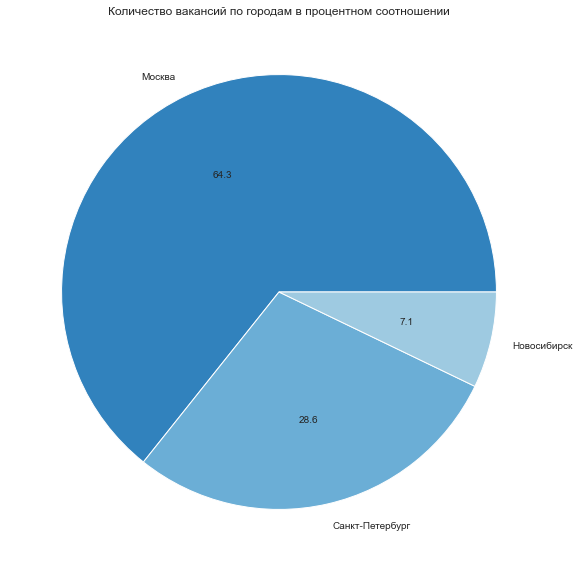

In [42]:
# задаем область диаграммы
fig, (ax) = plt.subplots(figsize=(10,10))
# устанавливаем заголовки для графиков
ax.set_title('Количество вакансий по городам в процентном соотношении')
ax.pie(data_region['count'], autopct='%.1f', labels=data_region['region_name'])
plt.show()

Также нужно понять, много ли закрытых вакансий в выборке, и много ли вакансий с частичной занятостью:

In [43]:
def make_pivot(df,column_for_index, column_to_count):
    pivot = df.pivot_table(index = column_for_index,
                          values = column_to_count,
                          aggfunc = 'count')\
    .reset_index().rename(columns={column_to_count: 'count'}).sort_values(by='count', ascending=False)
    return pivot

Заодно посмотрим и на распределение требуемого опыта в целом, хотя это особо ни о чем не говорит:

In [44]:
columns_for_index = ['vacancy_type', 'employment_form_type', 'experience_type']
column_to_count = ['type_name', 'employment_form_name', 'experience_name']

In [45]:
for i,j in zip(columns_for_index, column_to_count):
    display(make_pivot(data_flat, i, j))

,vacancy_type,count
0,open,1400


,employment_form_type,count
0,FULL,1400


,experience_type,count
0,between1And3,600
1,between3And6,600
2,noExperience,200


Успех: в полученной выборке все вакансии открытые и с полной занятостью. Это странно, но возможно API HH по умолчанию отдает выборку вакансий по определенным условиям. Удача в том, что именно такие вакансии мне и нужны, поэтому использую всю выборку без дополнительных фильтров.  
В дальнейшем потребуется только проверить распреление ЗП по городам. В выборке все города - российские, но возможно, что где-то указана ЗП не в рублях. Проверим:

In [46]:
print('Количество вакансий по указанной валюте:', '\n', 60*'-','\n',
      data_flat['salary_currency'].value_counts())

Количество вакансий по указанной валюте: 
 ------------------------------------------------------------ 
 RUR    1400
Name: salary_currency, dtype: int64


Отлично, все данные только в рублях. И я еще не проверила, какое количество цифр gross, а какое net:

In [47]:
print('Количество вакансий с указанием ЗП до и после вычета налогов:','\n', 60*'-','\n',
     data_flat['gross'].value_counts())

Количество вакансий с указанием ЗП до и после вычета налогов: 
 ------------------------------------------------------------ 
 False    1000
True      400
Name: gross, dtype: Int64


Большая часть вакансий - 1000 - содержит все-таки уровень net, то есть на руки, после вычета налогов. Остальные 400 - это уровень до вычета налогов. Учтем это далее.

#### Распределение ЗП по всей выборке

Оценим максимальный и минимальный указанный уровень зарплаты От:

In [48]:
print('Максимальная ЗП От, RUB:', '\n', 60*'-','\n',
     data_flat['salary_from'].max())
print('Минимальная ЗП От, RUB:', '\n', 60*'-','\n',
     data_flat['salary_from'].min())

Максимальная ЗП От, RUB: 
 ------------------------------------------------------------ 
 300000
Минимальная ЗП От, RUB: 
 ------------------------------------------------------------ 
 0


Здесь пока присутствуют вакансии, где не указан уровень зарплаты От. Так вышло, что изначально я отфильтровывала данные, где вообще не указан никакой уровень - ни От, ни До. Пока эти нулевые данные отфильтровывать не буду, возможно, позже избавимся от них.

In [49]:
print('Максимальная ЗП До, RUB:', '\n', 60*'-','\n',
     data_flat['salary_to'].max())

Максимальная ЗП До, RUB: 
 ------------------------------------------------------------ 
 380000


Посмотрим на общее распределение и поищем выбросы в данных:

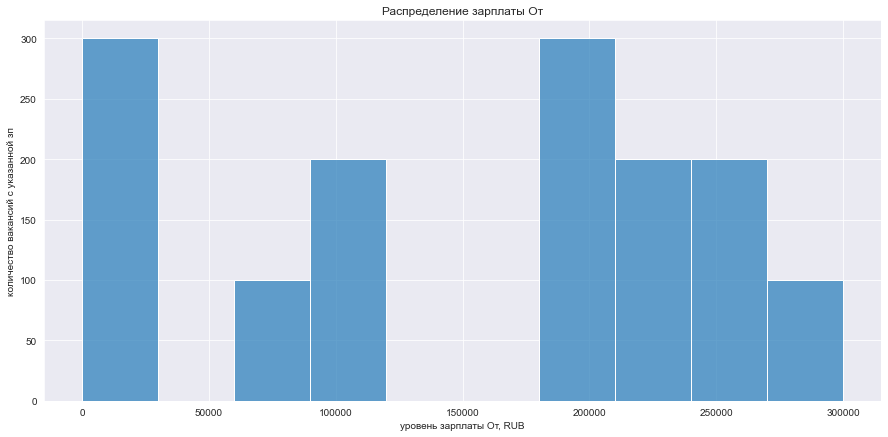

In [50]:
fig,ax = plt.subplots(figsize=(15,7))
sns.histplot(data_flat['salary_from'], bins=10)
ax.set_title('Распределение зарплаты От')
ax.set_xlabel('уровень зарплаты От, RUB') # ЗП в другой валюте в выборке не было
ax.set_ylabel('количество вакансий с указанной зп')
plt.show()

1. Значение 0 - это вакансии, где не указан уровень зарплаты От. Таких было всего 300;
2. Еще 100 вакансий попадают в промежуток, где зарплата начинается примерно от `70 000 руб`. Скорее всего, это вакансии "без опыта", проверим это далее. И еще 200 вакансий - от `90 000 руб`. Пока мои предположения, что все эти 300 вакансий относятся в группу "без опыта", либо они в Новосибирске. Точнее это будет видно далее в распределении по городам и по опыту;
3. Интересно, что в промежутке От `120 000 - 180 000` нет ни одной вакансии. Зато, начиная `От 180 000 руб` лежит основная масса вакансий;
4. Самое большое количество - 300 вакансий - находится в промежутке От `180 000 - 210 000 руб`, и это самая интересная информация. Подавляющее количество вакансий - это вакансии из Москвы, их 900 и 64% от всей выборки соответственно. По другим исследованиям, уровень ЗП в Санкт-Петербурге обычно чуть ниже, чем в Москве. В нашей выборке всего три города - Москва, Питер и Новосибирск, и вряд ли вакансии из Новосибирска опережают вакансии из Москвы. Что намекает на тот факт, что реальный уровень зарплаты От по Москве может быть еще чуть выше;
4. 400 вакансий находятся в промежутке От `210 000 - 270 000 руб` - по 200 вакансий в группах `210 000 - 240 000 руб` и `240 000 - 270 000 руб` соответственно. Учитывая всё, написанное выше, нужно смотреть подробнее, т.к. из этого графика невозможно сказать, что вызывает перекос - город или уровень опыта;
5. Небольшая часть вакансий в количестве 100 лежит в пределах От `270 000 - 300 000 руб`, и вот это почти наверняка вакансии сеньоров. Вычислить их сможем по указанному требуемому опыту далее.  

В целом уровень ЗП От `70 000 - 90 000 руб` по всей России я бы выбросом не считала. Но лично для меня это выброс)) Далее буду отфильтровывать данные только по Москве, и там уже будет точнее видно, учитывать ли этот уровень.

Для чистоты эксперимента построим аналогичный график по уровню ЗП До. Таких вакансий с указанным уровнем До было меньше - 800 против 1100 (указано От).

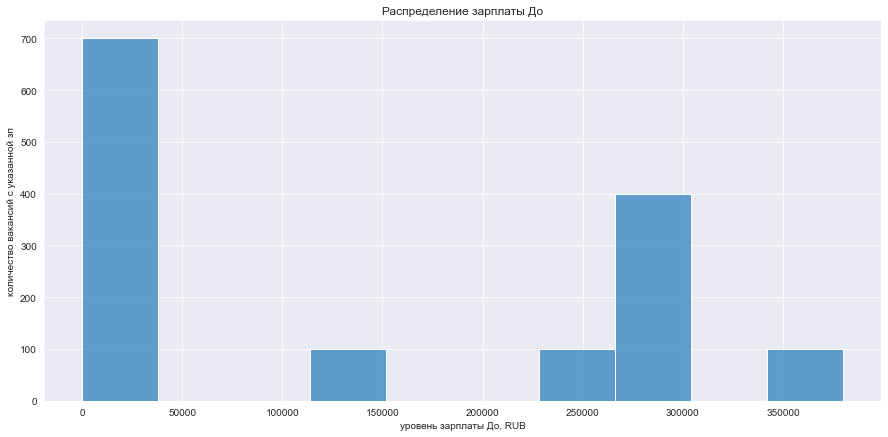

In [51]:
fig,ax = plt.subplots(figsize=(15,7))
sns.histplot(data_flat['salary_to'], bins=10)
ax.set_title('Распределение зарплаты До')
ax.set_xlabel('уровень зарплаты До, RUB') # ЗП в другой валюте в выборке не было
ax.set_ylabel('количество вакансий с указанной зп')
plt.show()

Здесь действительно намного меньше интересных данных, но в любом случае неплохо знать потолок))  
1. Подавляющее большинство - 400 вакансий - попадают в промежуток ЗП До `260 000 - 300 000 руб`. Это половина всех имеющихся данных;
2. По 100 вакансий попадают в промежутки До: `110 000 - 150 000 руб`, `230 000 - 260 000 руб` и `340 000 - 380 000 руб`. Это похоже на ставки джуна, мидла и сеньора, но ориентироваться на эти данные, пожалуй, не буду по двум причинам:  
- потолок у каждого личный, обычно это больше зависит от договоренности с компанией;
- далеко не везде указаны цифры и От и До, данных маловато для того, чтобы принимать небольшие группки До в качестве уверенной статистики.

#### Распределение по Москве

Меня интересуют только вакансии из Москвы, поэтому выберу нужные данные по региону (Москва - регион 1).  
Также помним, что при преобразовании столбцов `salary_...` незаполненные строки превратились в 0, поэтому инфо покажет, что они не пустые, но при этом ценности такие строки в себе не несут. Ориентируемся на указанный уровень зарплаты От:

In [52]:
data_moscow = data_flat.query('region_id == 1 & salary_from != 0')

In [53]:
data_moscow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 700 entries, 0 to 1399
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    700 non-null    int32  
 1   vacancy_name          700 non-null    object 
 2   salary_from           700 non-null    int64  
 3   salary_to             700 non-null    int64  
 4   salary_currency       700 non-null    object 
 5   gross                 700 non-null    boolean
 6   region_id             700 non-null    int32  
 7   region_name           700 non-null    object 
 8   region_url            700 non-null    object 
 9   vacancy_type          700 non-null    object 
 10  type_name             700 non-null    object 
 11  employment_form_type  700 non-null    object 
 12  employment_form_name  700 non-null    object 
 13  experience_type       700 non-null    object 
 14  experience_name       700 non-null    object 
dtypes: boolean(1), int32(2

Неплохо. Всего было 900 вакансий из Москвы, потеряли 200. Жаль, но в любом случае это неинформативные данные.

Составим общее распределение:

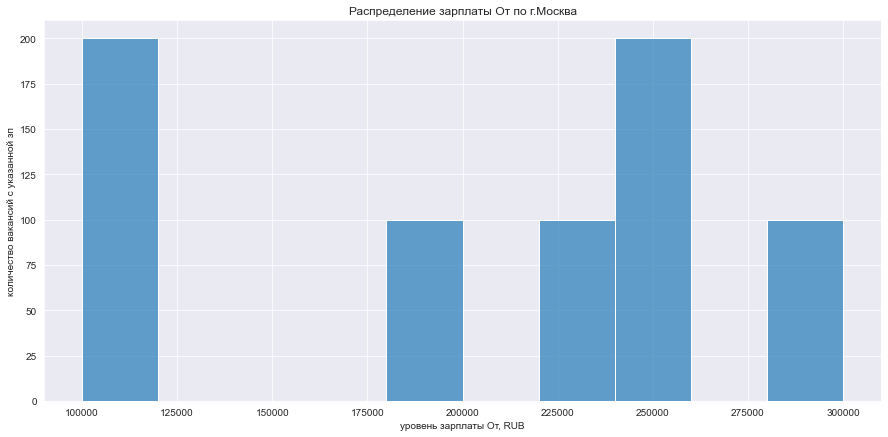

In [54]:
fig,ax = plt.subplots(figsize=(15,7))
sns.histplot(data_moscow['salary_from'], bins=10)
ax.set_title('Распределение зарплаты От по г.Москва')
ax.set_xlabel('уровень зарплаты От, RUB') # ЗП в другой валюте в выборке не было
ax.set_ylabel('количество вакансий с указанной зп')
plt.show()

Явно преобладают две группы по 200 вакансий в каждой:  
- От 100 000 руб до 120 000 руб;
- От 245 000 руб до 260 000 руб;  

В целом распределение достаточно типичное и очень похоже на реальные цифры в вакансиях, которые я видела.

#### Распределение по уровням junior, middle, senior по Москве

Наконец-то сгруппируем вакансии по требуемому опыту. В выборке есть три варианта опыта, будем считать, что они соответствуют уровням джун, миддл и сеньор+лид, понимая, что это разделение достаточно условное:

In [55]:
def check_level(str):
    if 'between3And6' in str:
        str = 'senior'
    elif 'between1And3' in str:
        str = 'middle'   
    elif 'noExperience' in str:
        str = 'junior'
    else:
        str = 'unknown'
    return str

In [56]:
data_moscow['level'] = data_moscow['experience_type'].apply(check_level)

C:\Users\HP\AppData\Local\Temp/ipykernel_14636/1848097984.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_moscow['level'] = data_moscow['experience_type'].apply(check_level)


Построим графики распределения по уровню ЗП для каждого уровня. Для начала рассчитаем медианную ЗП для каждого уровня:

In [57]:
median_salary = data_moscow.pivot_table(index='level',
                                       values='salary_from',
                                       aggfunc=['count', 'median','mean', 'max', 'min'])\
.reset_index()
median_salary.columns = ['level', 'vacancy_count', 'median_salary', 'mean_salary', 'max_salary', 'min_salary']

In [58]:
median_salary

,level,vacancy_count,median_salary,mean_salary,max_salary,min_salary
0,junior,100,100000,100000.000000,100000,100000
1,middle,300,240000,196666.666667,250000,100000
2,senior,300,230000,236666.666667,300000,180000


И вот тут получили забавный момент - у сеньора медианная зарплата ниже, чем у мидла) При этом по средней, максимальной и минимальной ЗП такой проблемы нет, все идет ровно по возрастанию. Возможно, распределение по опыту работы - не самое показательное, как и ожидалось)  
Медиана означает, что ровно половина всех вакансий ниже этой цифры, а половина выше. Вакансий миддлов и сеньоров поровну, что наводит на мысли о выбросах в данных.  
Проверим. В идеале было бы построить тут boxplot, но данные слишком однородные, из-за того, что в вакансиях указывают примерно одинаковые уровни ЗП, и поэтому выбросы будут видны не так явно. Поэтому обойдемся гистограммой:

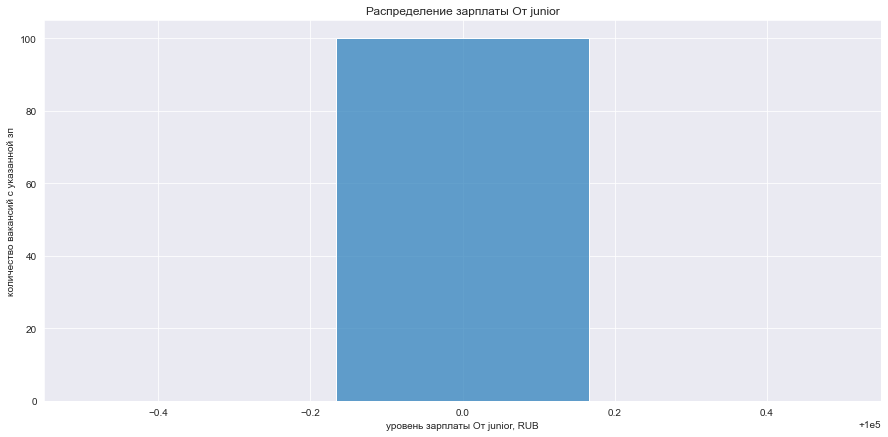

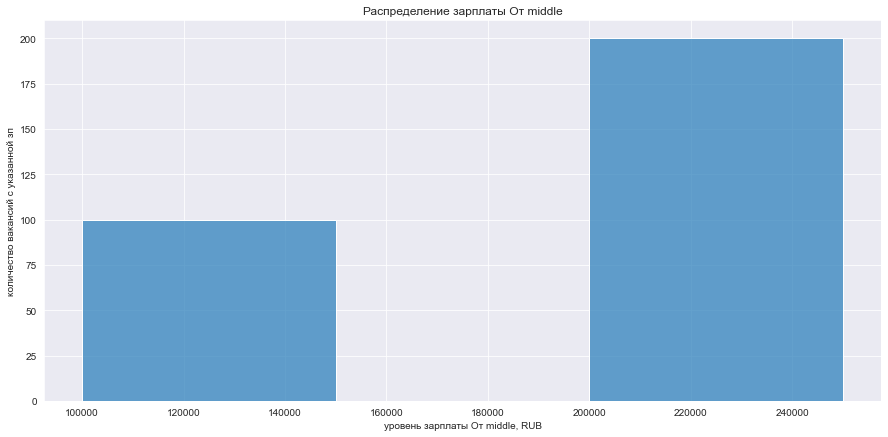

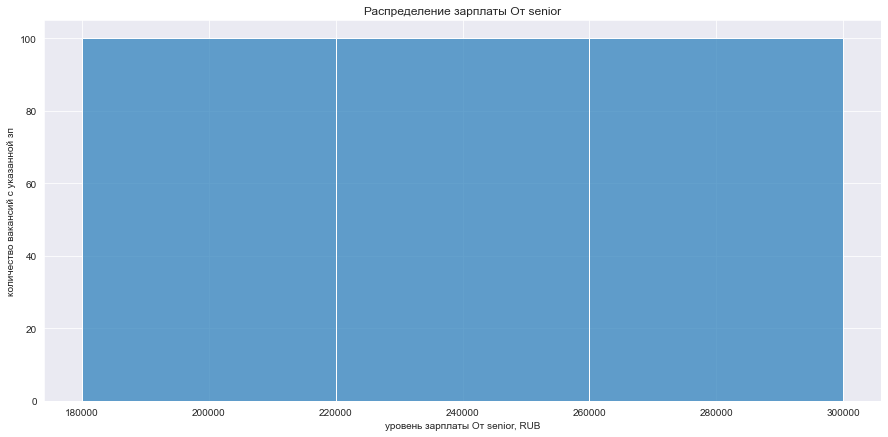

In [59]:
for i in data_moscow['level'].unique():
    filtered = data_moscow.query('level == @i')
    fig,ax = plt.subplots(figsize=(15,7))
    sns.histplot(filtered['salary_from'], bins=3)
    ax.set_title(f'Распределение зарплаты От {i}')
    ax.set_xlabel(f'уровень зарплаты От {i}, RUB') 
    ax.set_ylabel('количество вакансий с указанной зп')
    plt.show()

Уже показательнее.  
1. Для вакансий без опыта - я их обозначила как junior - все было очень однородно - `100 000 руб`, это и среднее, и медиана, и максимальное значение. Стабильность, ребята))
2. Для условных миддлов - 1-3 года опыта - есть четкое разделение. Треть вакансий - `от 100 000 руб до 150 000 руб`, а две трети - `от 200 000 до 250 000 руб`. И это несколько выше, чем фактический уровень зарплаты в зарплатном калькуляторе Хабра. Хорошие новости для 2025 года)
3. Непонятнее всего обстоят дела с условными сеньорами, но и нельзя опираться только на опыт 3-6 лет в данном случае (как и с миддлами, конечно). Для сеньоров вакансии разделились четко на три группы: `от 180 000 руб до 220 000 руб`, `от 220 000 руб до 260 000 руб` и `от 260 000 руб до 300 000 руб`. Из чего я делаю вывод, что настоящие сеньоры, вероятно, это только последняя группа (это похоже на данные зарплатного калькулятора). А вот группы до 260 000 руб - это миддлы с большим количеством опыта, возможно, middle+.

### Общий вывод

Фактический средний уровень зарплаты для системного аналитика уровня middle по данным зарплатного калькулятора Хабр составлял 170 000 руб. На январь 2025 г предложение превышает этот уровень - среднее значение составляет 196 000 руб, а медианное 240 000 руб. Такой разброс между средним и медианным значением вызван тем, что треть вакансий, попавших в группу миддлов, соответствует скорее уровню jumior - до 150 000 руб. Разделение за неимением других данных производилось по указанному опыту, а 1-3 года опыта вполне могут быть запрошены и для джуна. В любом случае ориентироваться стоит на собственный опыт и на требования конкретной вакансии.